In [1]:
# Import dependencies
import os
from typing import List
import sys
from pathlib import Path
from tqdm.notebook import tqdm
sys.path.append(Path(os.getcwd()).parent.parent.as_posix())

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pybboxes as pbx

from ultralytics import SAM

from paths import *

## Posebowl Object Detection Dataset

### Check if the dataset is complete and accurate

In [7]:
train_imgs = os.listdir(POSEBOWL_OBJDET_DIR / 'images' / 'train')
val_imgs = os.listdir(POSEBOWL_OBJDET_DIR / 'images' / 'val')
test_imgs = os.listdir(POSEBOWL_OBJDET_DIR / 'images' / 'test')

train_labels = os.listdir(POSEBOWL_OBJDET_DIR / 'labels' / 'train')
val_labels = os.listdir(POSEBOWL_OBJDET_DIR / 'labels' / 'val')
test_labels = os.listdir(POSEBOWL_OBJDET_DIR / 'labels' / 'test')

In [4]:
# # Checking if all images have corresponding labels
# assert len(train_imgs) == len(train_labels), 'Number of training images and labels do not match'
# assert len(val_imgs) == len(val_labels), 'Number of validation images and labels do not match'
# assert len(test_imgs) == len(test_labels), 'Number of test images and labels do not match'
# print('Number of images and labels match for all datasets (train, val, test)')

# # Checking if all images are in jpg format
# assert all([img.endswith('.jpg') for img in train_imgs]), 'Not all training images are in jpg format'
# assert all([img.endswith('.jpg') for img in val_imgs]), 'Not all validation images are in jpg format'
# assert all([img.endswith('.jpg') for img in test_imgs]), 'Not all test images are in jpg format'
# print('All images are in jpg format')

# # Checking if all labels are in txt format
# assert all([label.endswith('.txt') for label in train_labels]), 'Not all training labels are in txt format'
# assert all([label.endswith('.txt') for label in val_labels]), 'Not all validation labels are in txt format'
# assert all([label.endswith('.txt') for label in test_labels]), 'Not all test labels are in txt format'
# print('All labels are in txt format')

# # Checking if all labels are in YOLO format
# assert all([len(np.loadtxt(POSEBOWL_OBJDET_DIR / 'labels' / 'train' / label)) == 5 for label in train_labels]), 'Not all training labels are in YOLO format'
# assert all([len(np.loadtxt(POSEBOWL_OBJDET_DIR / 'labels' / 'val' / label)) == 5 for label in val_labels]), 'Not all validation labels are in YOLO format'
# assert all([len(np.loadtxt(POSEBOWL_OBJDET_DIR / 'labels' / 'test' / label)) == 5 for label in test_labels]), 'Not all test labels are in YOLO format'
# print('All labels are in YOLO format')

# # Check there exists a label for each image
# assert all([img.replace('.jpg', '.txt') in train_labels for img in train_imgs]), 'Not all training images have corresponding labels'
# assert all([img.replace('.jpg', '.txt') in val_labels for img in val_imgs]), 'Not all validation images have corresponding labels'
# assert all([img.replace('.jpg', '.txt') in test_labels for img in test_imgs]), 'Not all test images have corresponding labels'
# print('All images have corresponding labels')

"""Output:
    Number of images and labels match for all datasets (train, val, test)
    All images are in jpg format
    All labels are in txt format
    All labels are in YOLO format
    All images have corresponding labels
"""

Number of images and labels match for all datasets (train, val, test)
All images are in jpg format
All labels are in txt format
All labels are in YOLO format
All images have corresponding labels


### Try Segmentation with [SAM2](https://docs.ultralytics.com/models/sam-2/#sam-2-prediction-examples)

In [8]:
# Sampling 10 images from each dataset split
sample_imgs = {
    "train": np.random.choice(train_imgs, 10),
    "val": np.random.choice(val_imgs, 10),
    "test": np.random.choice(test_imgs, 10),
}

In [4]:
def plot_images_bbox(sample_imgs: List[str], split: str="train"):
    """
    Plot sample images with bounding boxes
    
    Args:
        - sample_imgs: List of 10 image file names to plot
        - split: Dataset split to plot images from (train, val, test)
    
    Returns:
        - None
    """
    sample_labels = [img.replace(".jpg", ".txt") for img in sample_imgs]
    
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle(f"Image samples with bounding boxes [{split}]")
    axs = axs.ravel()

    for i, (img, label) in enumerate(zip(sample_imgs, sample_labels)):
        # Read the image
        img = cv2.imread(str(POSEBOWL_OBJDET_DIR / "images" / split / img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_h, img_w, _ = img.shape

        # Read the bounding box coordinates
        with open(POSEBOWL_OBJDET_DIR / "labels" / split / label, "r") as f:
            lines = f.readlines()
            for line in lines:
                # Read yolo coordinates
                _, x, y, w, h = line.strip().split(" ")
                x, y, w, h = float(x), float(y), float(w), float(h)

                # Convert the yolo coordinates to integers
                x_tl, y_tl, x_br, y_br = pbx.convert_bbox(
                    (x, y, w, h), from_type="yolo", to_type="voc", image_size=(img_w, img_h)
                )

                # Draw the bounding box
                img = cv2.rectangle(
                    img,
                    (x_tl, y_tl),
                    (x_br, y_br),
                    (255, 0, 0),
                    2,
                )

        axs[i].imshow(img)
        axs[i].set_title(os.path.splitext(sample_imgs[i])[0])
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
# Loading SAM2-base model
sam_model = SAM(MODELS_DIR / "sam2_b.pt")
sam_model.info()

100%|██████████| 154M/154M [00:09<00:00, 17.2MB/s] 


Model summary: 566 layers, 80,833,666 parameters, 80,833,666 gradients


(566, 80833666, 80833666, 0.0)

In [74]:
def bbox_prompted_segmentation(sam_model: object, sample_imgs: List[str], split: str = "train"):
    """
    Perform segmentation on sample images with bounding box prompts
    
    Args:
        - sam_model: SAM model object
        - sample_imgs: List of 10 image file names to segment
        - split: Dataset split to segment images from (train, val, test)
    
    Returns:
        - None
    """
    # Image and Label paths
    img_paths = [POSEBOWL_OBJDET_DIR / "images" / split / img for img in sample_imgs]
    bbox_paths = [POSEBOWL_OBJDET_DIR / "labels" / split / img.replace(".jpg", ".txt") for img in sample_imgs]
    

    # Read the images
    images = [
        Image.open(img_path)
        for img_path in img_paths
    ]

    # Read the bounding box coordinates
    yolo_bboxes = [
        np.loadtxt(bbox_path)
        for bbox_path in bbox_paths
    ]
    img_bboxes = [
        pbx.convert_bbox(
            (x, y, w, h), from_type="yolo", to_type="voc", image_size=img.size
        )
        for i, (_, x, y, w, h) in enumerate(yolo_bboxes)
    ]
    
    # Plot a 2x5 grid of masks
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle(f"Segmentation results [{split}]")
    axs = axs.ravel()
    
    for i, img_path in tqdm(enumerate(img_paths), desc="Segmenting images", total=len(img_paths)):
        # Perform segmentation    
        results = sam_model(img_path, bboxes=img_bboxes[i], verbose=False)
        mask = results[0].masks.data.cpu().numpy().astype(np.uint8).squeeze(0) * 255

        axs[i].imshow(mask, cmap="gray")
        axs[i].set_title(f"{os.path.splitext(sample_imgs[i])[0]}")
        axs[i].axis("off")
        
    plt.tight_layout()
    plt.show()
    

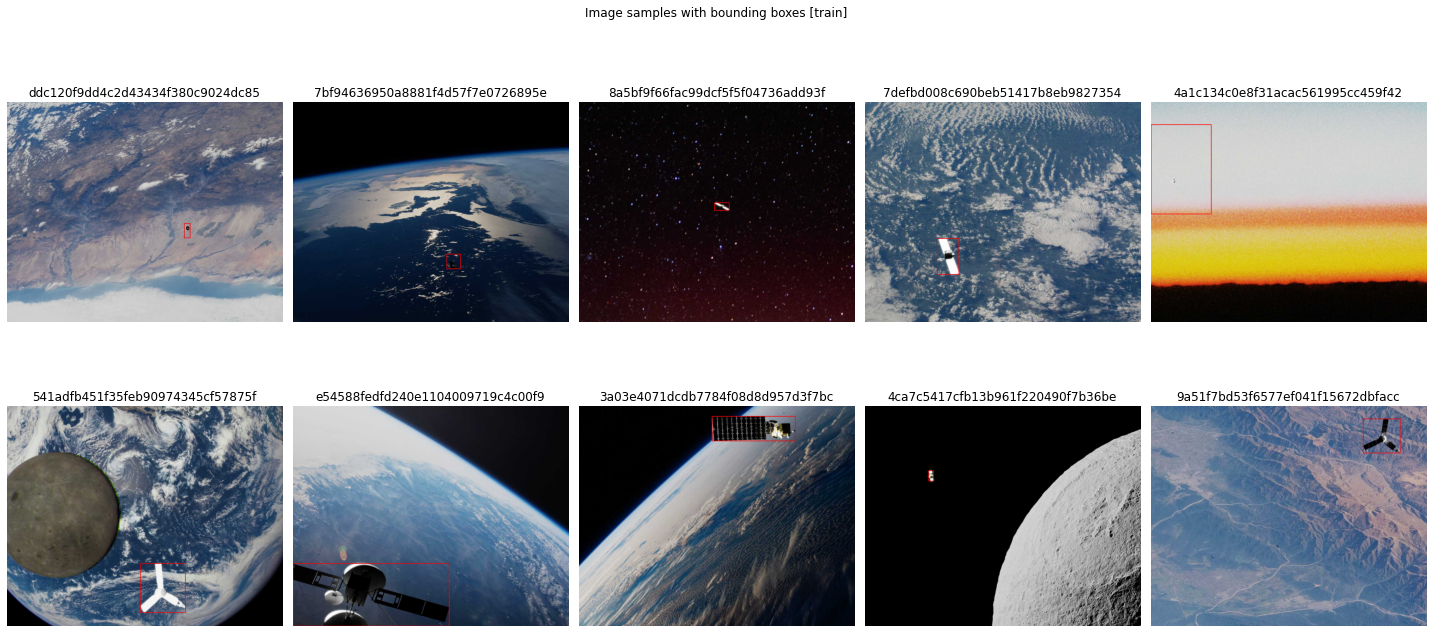

Segmenting images:   0%|          | 0/10 [00:00<?, ?it/s]

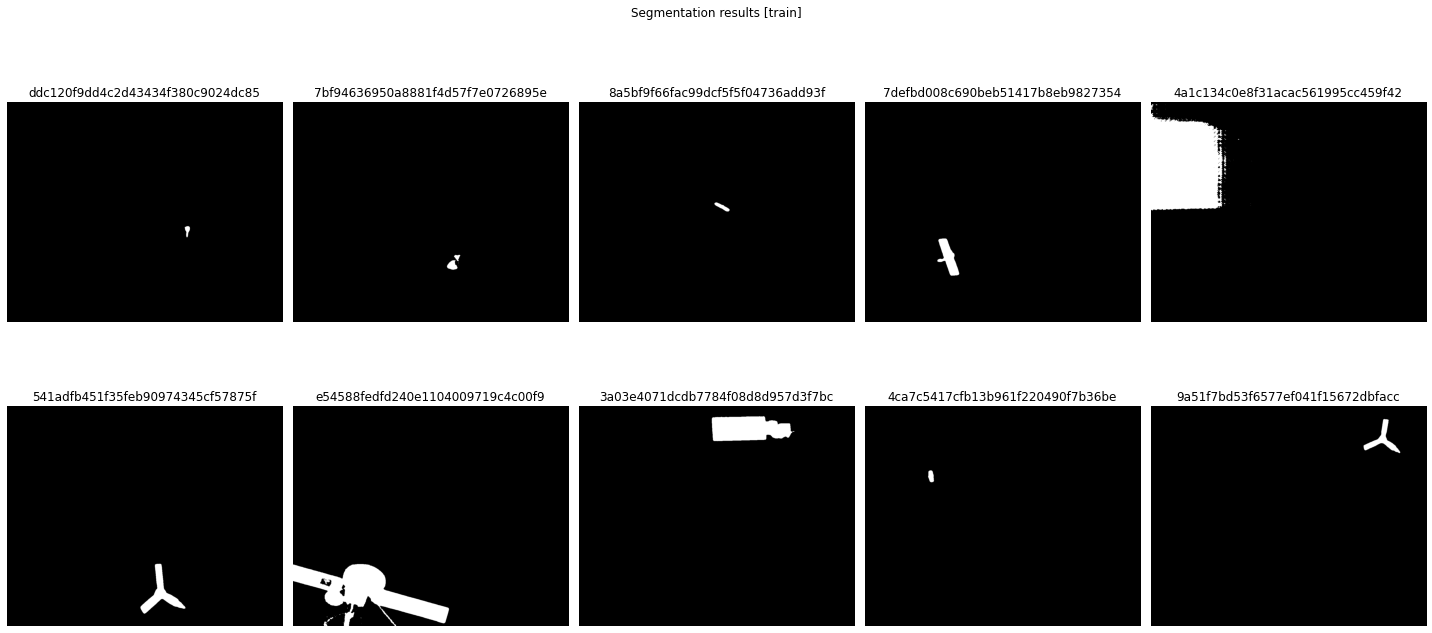

In [75]:
# Show a sample of 10 images and its corresponding bounding boxes from the training dataset
plot_images_bbox(sample_imgs["train"], split="train")

# Perform segmentation on the sampled images [train]
bbox_prompted_segmentation(sam_model, sample_imgs["train"], split="train")

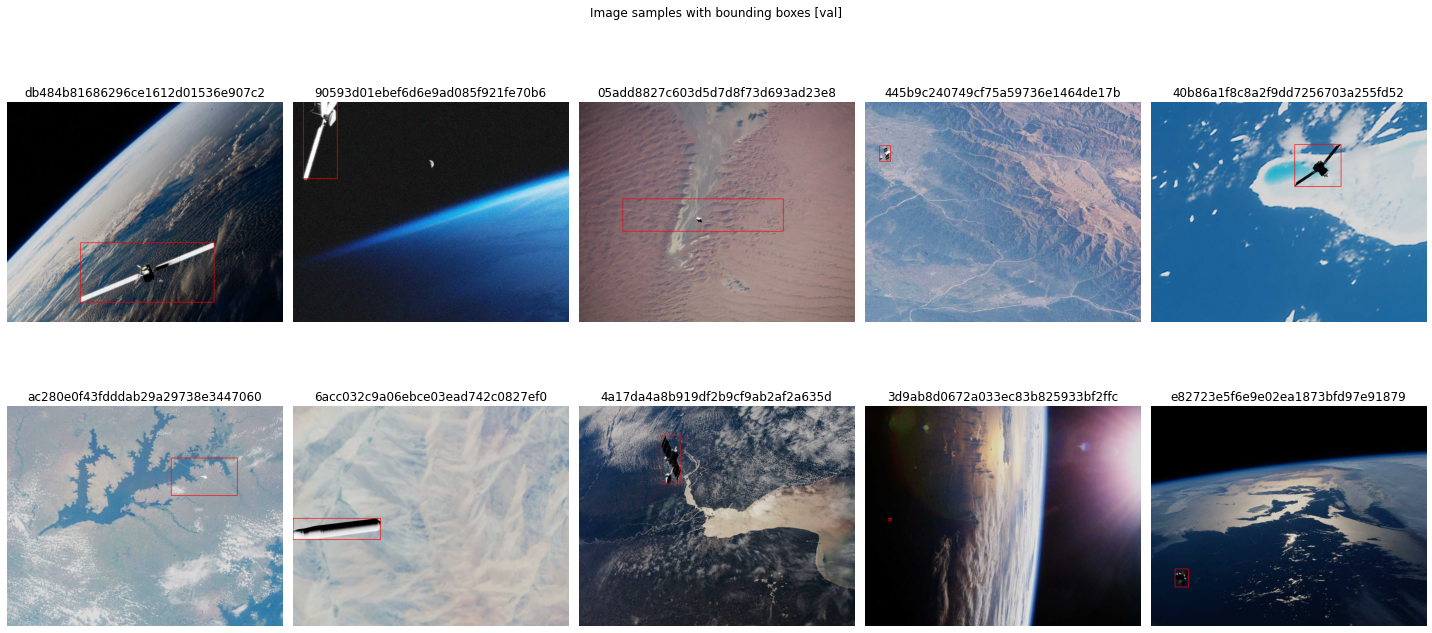

Segmenting images:   0%|          | 0/10 [00:00<?, ?it/s]

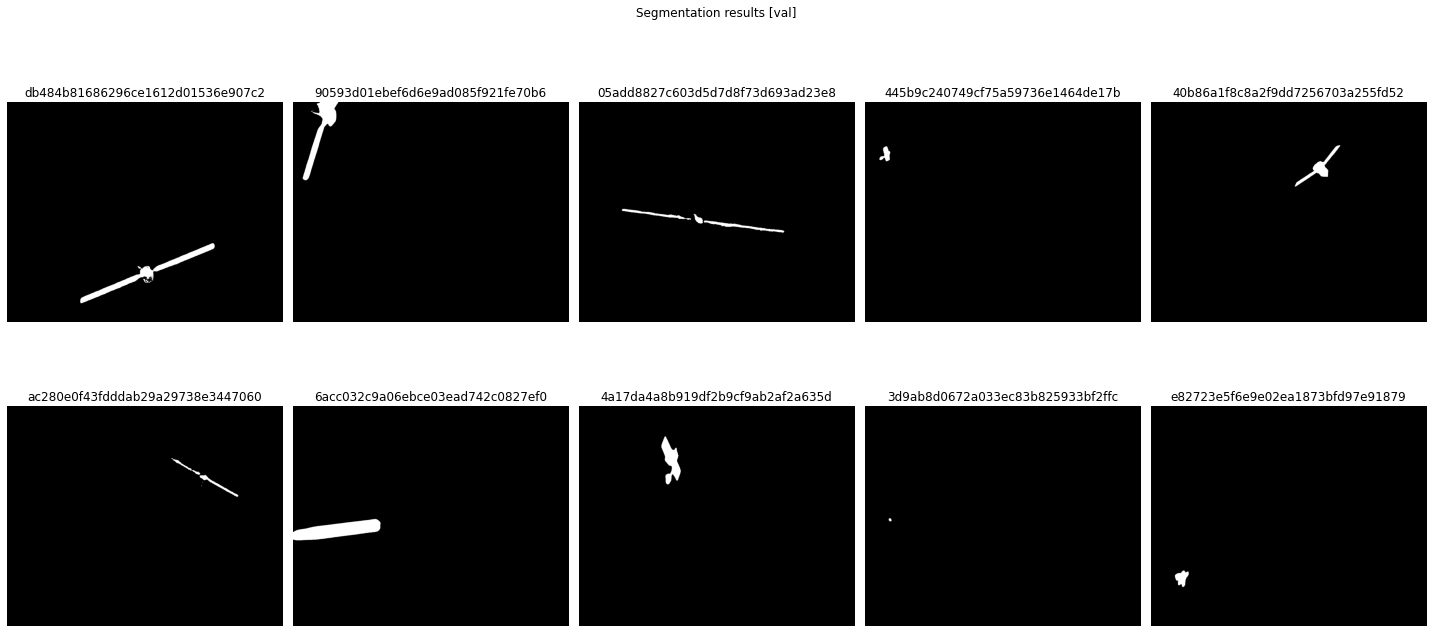

In [76]:
# Show a sample of 10 images and its corresponding bounding boxes from the validation dataset
plot_images_bbox(sample_imgs["val"], split="val")

# Perform segmentation on the sampled images [validation]
bbox_prompted_segmentation(sam_model, sample_imgs["val"], split="val")

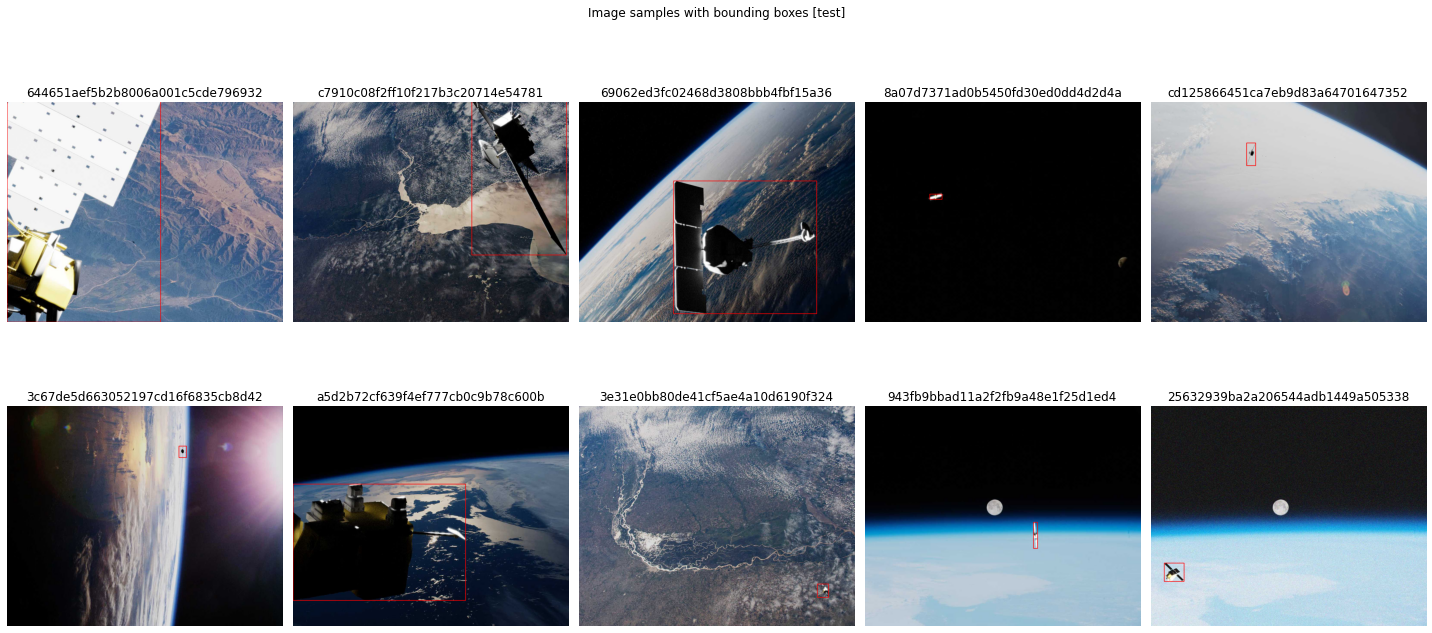

Segmenting images:   0%|          | 0/10 [00:00<?, ?it/s]

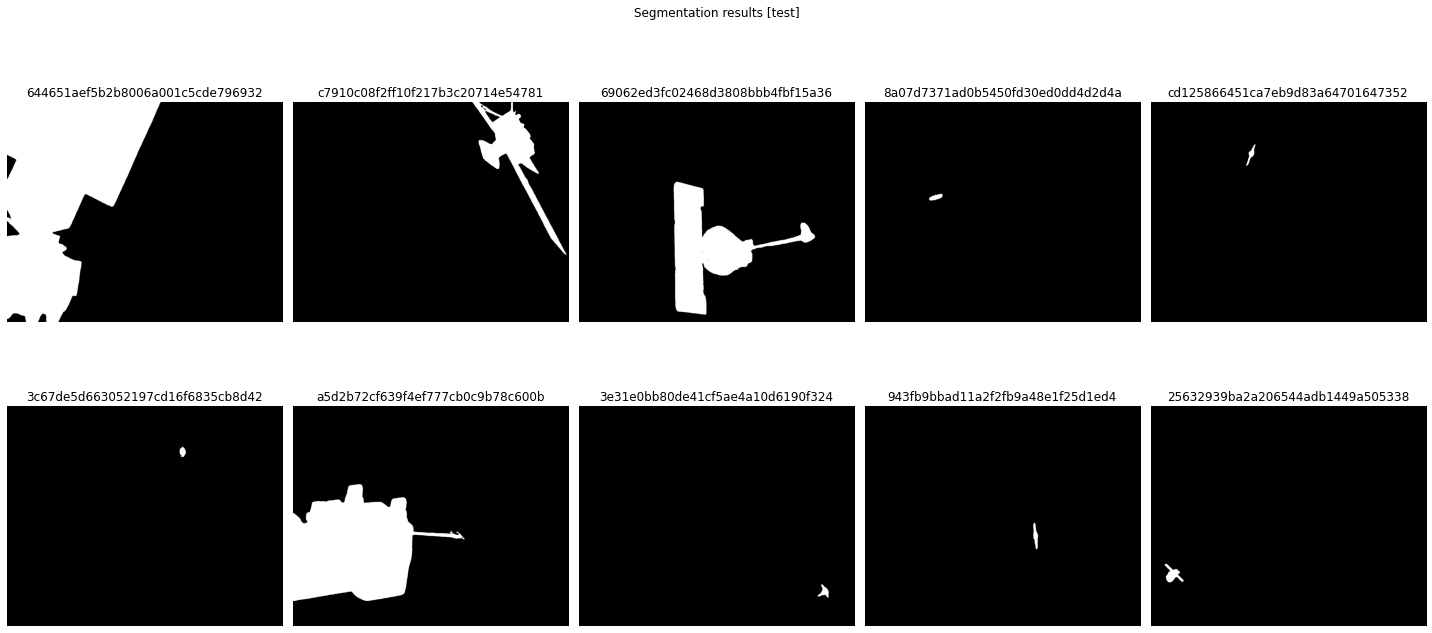

In [77]:
# Show a sample of 10 images and its corresponding bounding boxes from the test dataset
plot_images_bbox(sample_imgs["test"], split="test")

# Perform segmentation on the sampled images [test]
bbox_prompted_segmentation(sam_model, sample_imgs["test"], split="test")